In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
cr_loan_prep = pd.read_csv('cr_loan_w2.csv')

# Model evaluation and implementation

In [38]:
X = cr_loan_prep.drop('loan_status', axis=1)
y = cr_loan_prep[['loan_status']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

In [39]:
# Train the logistic regression model
clf_logistic = LogisticRegression().fit(X_train, np.ravel(y_train))

In [53]:
# Create predictions of probability for loan status using test data
logistic_preds = clf_logistic.predict_proba(X_test)

In [55]:
# Create dataframes of first five predictions, and first five true labels
logistic_preds_df = pd.DataFrame(logistic_preds[:,1][0:5], columns = ['prob_default'])
true_df = y_test.head()

In [57]:
# Concatenate and print the two data frames for comparison
preds_df_lr = pd.concat([true_df.reset_index(drop = True), logistic_preds_df], axis = 1)
print(preds_df_lr)

   loan_status  prob_default
0            1      0.445779
1            1      0.223447
2            0      0.288558
3            0      0.169358
4            1      0.114182


In [43]:
xgb.set_config(verbosity=0)
# Train a xgboost model
clf_gbt = xgb.XGBClassifier(use_label_encoder =False).fit(X_train, np.ravel(y_train))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [44]:
# Predict with a model
gbt_preds = clf_gbt.predict_proba(X_test)

In [45]:
# Create dataframes of first five predictions, and first five true labels
gbt_preds_df = pd.DataFrame(gbt_preds[:,1][0:5], columns = ['prob_default'])
true_df = y_test.head()

In [46]:
# Concatenate and print the two data frames for comparison
preds_df_gbt = pd.concat([true_df.reset_index(drop = True), gbt_preds_df], axis = 1)
print(preds_df_gbt)

   loan_status  prob_default
0            1      0.990942
1            1      0.983987
2            0      0.000807
3            0      0.001239
4            1      0.084892


## Comparing model report

In [71]:
preds_df_lr = pd.read_csv('preds_df_lr.csv')
preds_df_gbt = pd.read_csv('preds_df_gbt.csv')

In [61]:
# Print the logistic regression classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_lr['loan_status'], target_names=target_names))

# Print the gradient boosted tree classification report
print(classification_report(y_test, preds_df_gbt['loan_status'], target_names=target_names))


              precision    recall  f1-score   support

 Non-Default       0.86      0.92      0.89      9198
     Default       0.62      0.46      0.53      2586

    accuracy                           0.82     11784
   macro avg       0.74      0.69      0.71     11784
weighted avg       0.81      0.82      0.81     11784

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9198
     Default       0.94      0.73      0.82      2586

    accuracy                           0.93     11784
   macro avg       0.93      0.86      0.89     11784
weighted avg       0.93      0.93      0.93     11784



In [62]:
# Print the default F-1 scores for the logistic regression
print(precision_recall_fscore_support(y_test,preds_df_lr['loan_status'], average = 'macro')[2])

# Print the default F-1 scores for the gradient boosted tree
print(precision_recall_fscore_support(y_test,preds_df_gbt['loan_status'], average = 'macro')[2])

0.7108943782814463
0.8909014142736051


The scores from the classification_report() are all higher for the gradient boosted tree? This means the tree model is better in all of these aspects.

## Comparing with ROCs

In [63]:
# ROC chart components
clf_logistic_preds = logistic_preds[:, 1]
clf_gbt_preds = gbt_preds[:, 1]

fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(y_test, clf_logistic_preds)
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test, clf_gbt_preds)

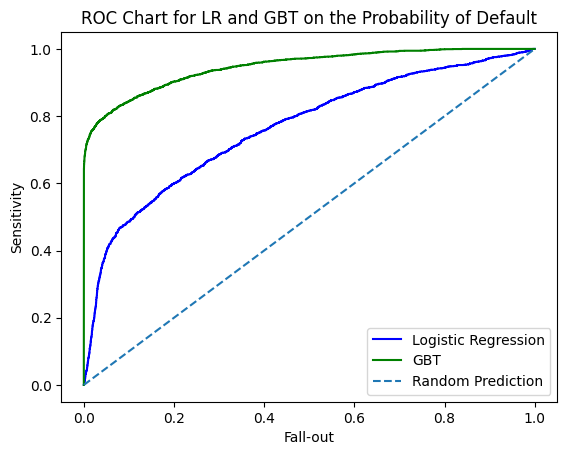

In [64]:
# ROC Chart with both
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

In [65]:
# Print the logistic regression AUC with formatting
print("Logistic Regression AUC Score: %0.2f" % roc_auc_score(y_test, clf_logistic_preds))

Logistic Regression AUC Score: 0.76


In [66]:
# Print the gradient boosted tree AUC with formatting
print("Gradient Boosted Tree AUC Score: %0.2f" % roc_auc_score(y_test, clf_gbt_preds))

Gradient Boosted Tree AUC Score: 0.95


The ROC curve for the gradient boosted tree. Not only is the lift much higher, the calculated AUC score is also quite a bit higher. It's beginning to look like the gradient boosted tree is best.

## Calibration curves

In [67]:
mean_pred_val_lr = [0.02111464, 0.07548788, 0.12582662, 0.17502903, 0.22449499, 0.27491676, 
                    0.32488847, 0.37486698, 0.42302912, 0.47397249, 0.52304288, 0.57259508,
                    0.62200793, 0.67156702, 0.71909209, 0.77024859]

frac_of_pos_lr = [0.07886231, 0.06610942, 0.10835913, 0.13505074, 0.16063348, 0.18333333,
                  0.21268657, 0.24099099, 0.48036649, 0.72677596, 0.73354232, 0.70547945,
                  0.68, 0.73913043, 0.55555556, 0.4]

mean_pred_val_gbt = [0.01937249, 0.07211534, 0.12178284, 0.17298488, 0.22318428, 0.2716055,
                     0.32285183, 0.369344, 0.42164062, 0.47158214, 0.52230485, 0.57041398,
                     0.62149714, 0.67234764, 0.72826275, 0.77567046, 0.82827961, 0.87636708,
                     0.92830987, 0.98579916]

frac_of_pos_gbt = [0.01916168, 0.06385752, 0.12795793, 0.17460317, 0.21806854, 0.32620321,
                   0.32653061, 0.33333333, 0.40677966, 0.43181818, 0.6, 0.42105263,
                   0.31578947, 0.6875, 0.78571429, 0.83333333, 0.90697674, 0.95238095,
                   0.98850575, 1]

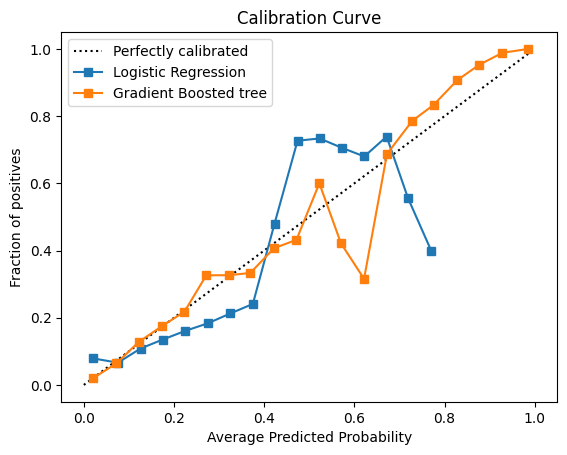

In [68]:
# Add the calibration curves for the logistic regression and the gradient boosted tree
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_pred_val_lr, frac_of_pos_lr,'s-', label='%s' % 'Logistic Regression')
plt.plot(mean_pred_val_gbt, frac_of_pos_gbt,'s-', label='%s' % 'Gradient Boosted tree')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.title('Calibration Curve')
plt.legend()
plt.show()

For the logistic regression, the calibration for probabilities starts off great but then gets more erratic as it the average probability approaches 0.4. Something similar happens to the gradient boosted tree around 0.5, but the model eventually stabilizes. We will be focusing on only the gbt model from now on.

# Credit acceptance rates

## Acceptance rates

In [72]:
# Check the statistics of the probabilities of default
print(preds_df_gbt['prob_default'].describe())

# Calculate the threshold for a 85% acceptance rate
threshold_85 = np.quantile(preds_df_gbt['prob_default'], 0.85)

# Apply acceptance rate threshold
preds_df_gbt['loan_status'] = preds_df_gbt['prob_default'].apply(lambda x: 1 if x > threshold_85 else 0)

# Print the counts of loan status after the threshold
print(preds_df_gbt['loan_status'].value_counts())

count    11784.000000
mean         4.991606
std         13.719224
min          0.000397
25%          0.141000
50%          0.741000
75%          4.622500
max        100.000000
Name: prob_default, dtype: float64
0    10025
1     1759
Name: loan_status, dtype: int64


## Visualizing quantiles of acceptance

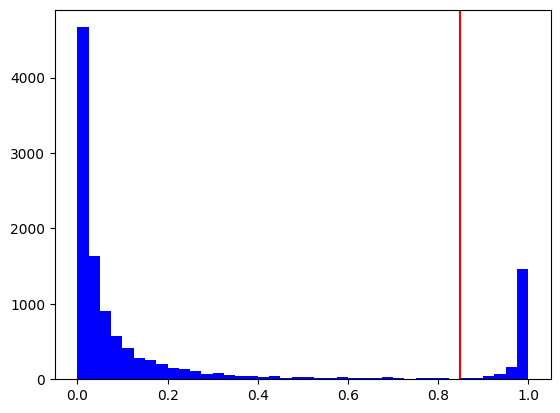

In [19]:
# Plot the predicted probabilities of default
plt.hist(clf_gbt_preds, color = 'blue', bins = 40)

# Calculate the threshold with quantile
threshold = np.quantile(clf_gbt_preds, 0.85)

# Add a reference line to the plot for the threshold
plt.axvline(x = threshold, color = 'red')
plt.show()

You can see where the threshold is on the range of predicted probabilities. Not only can you see how many loans will be accepted (left side), but also how many loans will be rejected (right side). I recommend that you re-run this code with different threshold values to better understand how this affects the acceptance rate.

## Bad rates

In [76]:
test_pred_df = pd.read_csv('test_pred_df.csv')

In [77]:
# Print the top 5 rows of the new data frame
print(test_pred_df.head())

# Create a subset of only accepted loans
accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]

# Calculate the bad rate
print(np.sum(accepted_loans['true_loan_status']) / accepted_loans['true_loan_status'].count())

   Unnamed: 0  true_loan_status  prob_default  pred_loan_status
0         0.0               1.0       0.98200               1.0
1         1.0               1.0       0.97500               1.0
2         2.0               0.0       0.00347               0.0
3         3.0               0.0       0.00546               0.0
4         4.0               1.0       0.12000               0.0
0.08256789137380191


The bad rate with the threshold set by the 85% quantile() is about 8%. This means that of all the loans we've decided to accept from the test set, only 8% were actual defaults! If we accepted all loans, the percentage of defaults would be around 22%.

## Acceptance rate impact

In [106]:
test_pred_df = pd.read_csv('test_pred_df_2.csv')

In [107]:
# Print the statistics of the loan amount column
print(test_pred_df['loan_amnt'].describe())

# Store the average loan amount
avg_loan = np.mean(test_pred_df['loan_amnt'])

# Set the formatting for currency, and print the cross tab
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(test_pred_df['true_loan_status'],
                 test_pred_df['pred_loan_status_15']).apply(lambda x: x * avg_loan, axis = 0))

count   $11,784.00
mean     $9,556.28
std      $6,238.01
min        $500.00
25%      $5,000.00
50%      $8,000.00
75%     $12,000.00
max     $35,000.00
Name: loan_amnt, dtype: float64
pred_loan_status_15              0              1
true_loan_status                                 
0                   $87,812,693.16     $86,006.56
1                    $7,903,046.82 $16,809,503.46


With this, we can see that our bad rate of about 8% represents an estimated loan value of about 7.9 million dollars. This may seem like a lot at first, but compare it to the total value of non-default loans! With this, we are ready to start talking about our acceptance strategy going forward.

# Credit strategy and minimum expected loss

## Making the strategy table


Before you implement a strategy, you should first create a strategy table containing all the possible acceptance rates you wish to look at along with their associated bad rates and threshold values. This way, you can begin to see each part of your strategy and how it affects your portfolio.

In [108]:
pd.options.display.float_format = '{:,.2f}'.format

In [109]:
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]
thresholds = [1.0, 0.992, 0.976, 0.804, 0.254, 0.178, 0.138, 0.111, 0.093, 0.078, 0.066, 0.055, 0.045, 0.037, 0.03, 0.022, 0.015, 0.008, 0.004, 0.002]
bad_rates = [0.219, 0.179, 0.132, 0.083, 0.061, 0.052, 0.043, 0.036, 0.03, 0.027, 0.023, 0.02, 0.017, 0.014, 0.01, 0.008, 0.005, 0.001, 0.0, 0.0]

In [110]:
# Populate the arrays for the strategy table with a for loop
for rate in accept_rates:
    # Calculate the threshold for the acceptance rate
    thresh = np.quantile(preds_df_gbt['prob_default'], rate).round(3)
    # Add the threshold value to the list of thresholds
    thresholds.append(np.quantile(preds_df_gbt['prob_default'], rate).round(3))
    # Reassign the loan_status value using the threshold
    test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    # Create a set of accepted loans using this acceptance rate
    accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])).round(3))

In [111]:
# Create a data frame of the strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Acceptance Rate','Threshold','Bad Rate'])

# Print the entire table
print(strat_df)

    Acceptance Rate  Threshold  Bad Rate
0              1.00       1.00      0.22
1              0.95       0.99      0.18
2              0.90       0.98      0.13
3              0.85       0.80      0.08
4              0.80       0.25      0.06
5              0.75       0.18      0.05
6              0.70       0.14      0.04
7              0.65       0.11      0.04
8              0.60       0.09      0.03
9              0.55       0.08      0.03
10             0.50       0.07      0.02
11             0.45       0.06      0.02
12             0.40       0.04      0.02
13             0.35       0.04      0.01
14             0.30       0.03      0.01
15             0.25       0.02      0.01
16             0.20       0.01      0.01
17             0.15       0.01      0.00
18             0.10       0.00      0.00
19             0.05       0.00      0.00


## Visualiazing the strategy

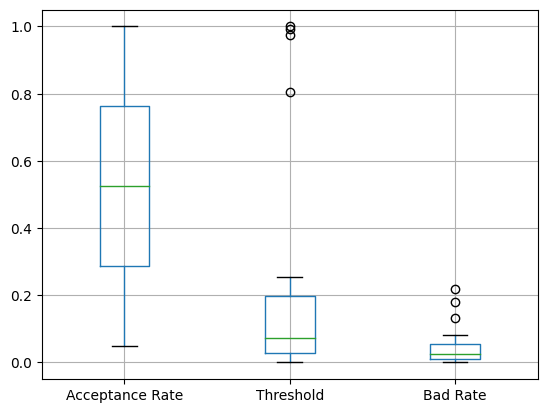

In [112]:
# Visualize the distributions in the strategy table with a boxplot
strat_df.boxplot()
plt.show()

The Acceptance Rate would be the independent variable with the Bad Rate as the dependent variable.

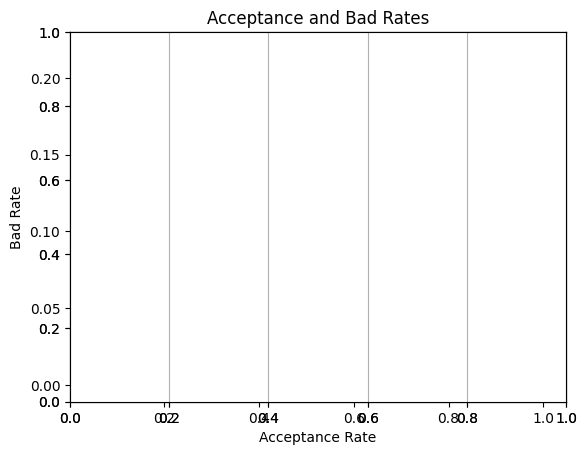

In [113]:
# Plot the strategy curve
plt.plot(strat_df['Acceptance Rate'], strat_df['Bad Rate'])
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()

The boxplot shows us the distribution for each column. Look at the strategy curve. The bad rates are very low up until the acceptance rate 0.6 where they suddenly increase. This suggests that many of the accepted defaults may have a prob_default value between 0.6 and 0.8.

## Estimated value profiling

In [116]:
strat_df = pd.read_csv('strat_df.csv')

    Unnamed: 0  Acceptance Rate  Threshold  Bad Rate  Num Accepted Loans  \
0            0             1.00       1.00      0.22               11379   
1            1             0.95       0.99      0.18               10591   
2            2             0.90       0.98      0.13               10025   
3            3             0.85       0.80      0.08                9390   
4            4             0.80       0.25      0.06                8857   
5            5             0.75       0.18      0.05                8229   
6            6             0.70       0.14      0.04                7685   
7            7             0.65       0.11      0.04                7104   
8            8             0.60       0.09      0.03                6456   
9            9             0.55       0.08      0.03                5870   
10          10             0.50       0.07      0.02                5288   
11          11             0.45       0.06      0.02                4726   
12          

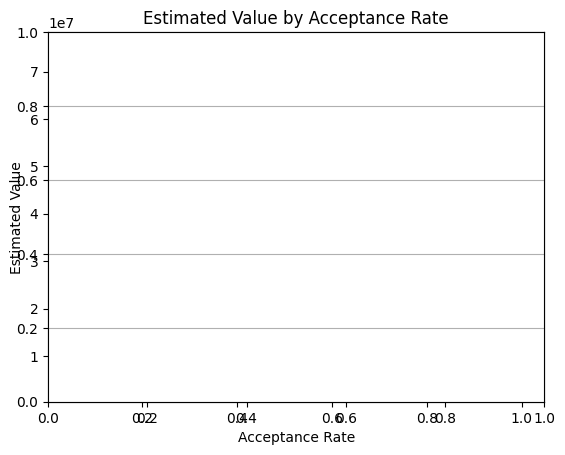

In [117]:
# Print the contents of the strategy df
print(strat_df)

# Create a line plot of estimated value
plt.plot(strat_df['Acceptance Rate'],strat_df['Estimated Value'])
plt.title('Estimated Value by Acceptance Rate')
plt.xlabel('Acceptance Rate')
plt.ylabel('Estimated Value')
plt.axes().yaxis.grid()
plt.show()

In [118]:
# Print the row with the max estimated value
print(strat_df.loc[strat_df['Estimated Value'] == np.max(strat_df['Estimated Value'])])

   Unnamed: 0  Acceptance Rate  Threshold  Bad Rate  Num Accepted Loans  \
3           3             0.85       0.80      0.08                9390   

   Avg Loan Amnt  Estimated Value  
3       9,556.28    74,800,000.00  


With our credit data and our estimated averag loan value, we clearly see that the acceptance rate 0.85 has the highest potential estimated value. Normally, the allowable bad rate is set, but we can use analyses like this to explore other options.

## Total expected loss

$Total Expected Loss = \sum_{x=1}^n{PD_x}*{LGD_x}*{EAD_x}$

In [120]:
test_pred_df = pd.read_csv('test_pred_df_3.csv')

In [121]:
# Print the first five rows of the data frame
print(test_pred_df.head())

# Calculate the bank's expected loss and assign it to a new column
test_pred_df['expected_loss'] = test_pred_df['prob_default'] * test_pred_df['loss_given_default'] * test_pred_df['loan_amnt']

# Calculate the total expected loss to two decimal places
tot_exp_loss = round(np.sum(test_pred_df['expected_loss']),2)

# Print the total expected loss
print('Total expected loss: ', '${:,.2f}'.format(tot_exp_loss))

   Unnamed: 0  true_loan_status  prob_default  loan_amnt  loss_given_default
0           0                 1          0.98      15000                   1
1           1                 1          0.97      11200                   1
2           2                 0          0.00      15000                   1
3           3                 0          0.01      10800                   1
4           4                 1          0.12       3000                   1
Total expected loss:  $27,086,726.89


This is the total expected loss for the entire portfolio using the gradient boosted tree. $27 million may seem like a lot, but the total expected loss would have been over $28 million with the logistic regression. Some losses are unavoidable, but your work here might have saved the company a million dollars!